# HR Attrition Prediction Project: Full Pipeline

This notebook details the end-to-end process of building and evaluating machine learning models to predict employee attrition. It covers data loading, comprehensive preprocessing and feature engineering, model training, evaluation, and final data export for Tableau visualization.

---

## 1. Environment Setup & Imports
This section handles all necessary library imports and defines any global control flags that might influence the execution of the subsequent sections.

In [56]:
# EDA.ipynb, Preprocessing.ipynb, Modeling.ipynb, Current_Snapshot.ipynb (Consolidated Imports)

# Core data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing and modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Imbalanced-learn for handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# XGBoost for gradient boosting
from xgboost import XGBClassifier

# SHAP for model interpretability
import shap

# For saving/loading preprocessors and models
import pickle

# ----- GLOBAL CONTROL FLAG -----
# Set to True if you want to overwrite the processed CSVs and model artifacts
# Set to False if you want to use existing processed files and skip re-running preprocessing/model training
overwrite_files = True # Set this to TRUE to re-process and re-train; set to False to use existing artifacts.

## 2. Data Loading
This section is dedicated to loading the raw dataset from its source. It's important to ensure the file path is correct and to perform an initial check on the data's basic structure.

In [57]:
# Data Loading (from EDA.ipynb and Preprocessing.ipynb)

# Load data
df = pd.read_csv('full summary.csv')

# Basic overview of the raw data
print("--- Raw Data Head ---")
print(df.head())
print("\n--- Raw Data Info ---")
print(df.info())
print("\n--- Raw Data Description ---")
print(df.describe())

--- Raw Data Head ---
   employee_id snapshot_date  age        department business_unit  \
0            1     30/4/2021   35  Customer Success    Commercial   
1            1     31/5/2021   35  Customer Success    Commercial   
2            1     30/6/2021   35  Customer Success    Commercial   
3            1     31/7/2021   35  Customer Success    Commercial   
4            1     31/8/2021   35  Customer Success    Commercial   

        job_title     location  base_salary  bonus_eligible  bonus_pct  ...  \
0  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
1  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
2  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
3  Senior Analyst  Seattle, WA        77073               0        0.0  ...   
4  Senior Analyst  Seattle, WA        77073               0        0.0  ...   

   job_level  last_training_date vacation_leave sick_leave personal_leave  \
0          

## 3. Exploratory Data Analysis (EDA)
This section performs in-depth analysis of the dataset to understand its characteristics, identify patterns, and visualize distributions and relationships.

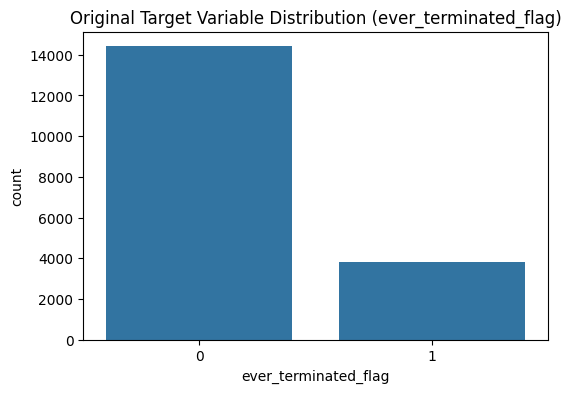

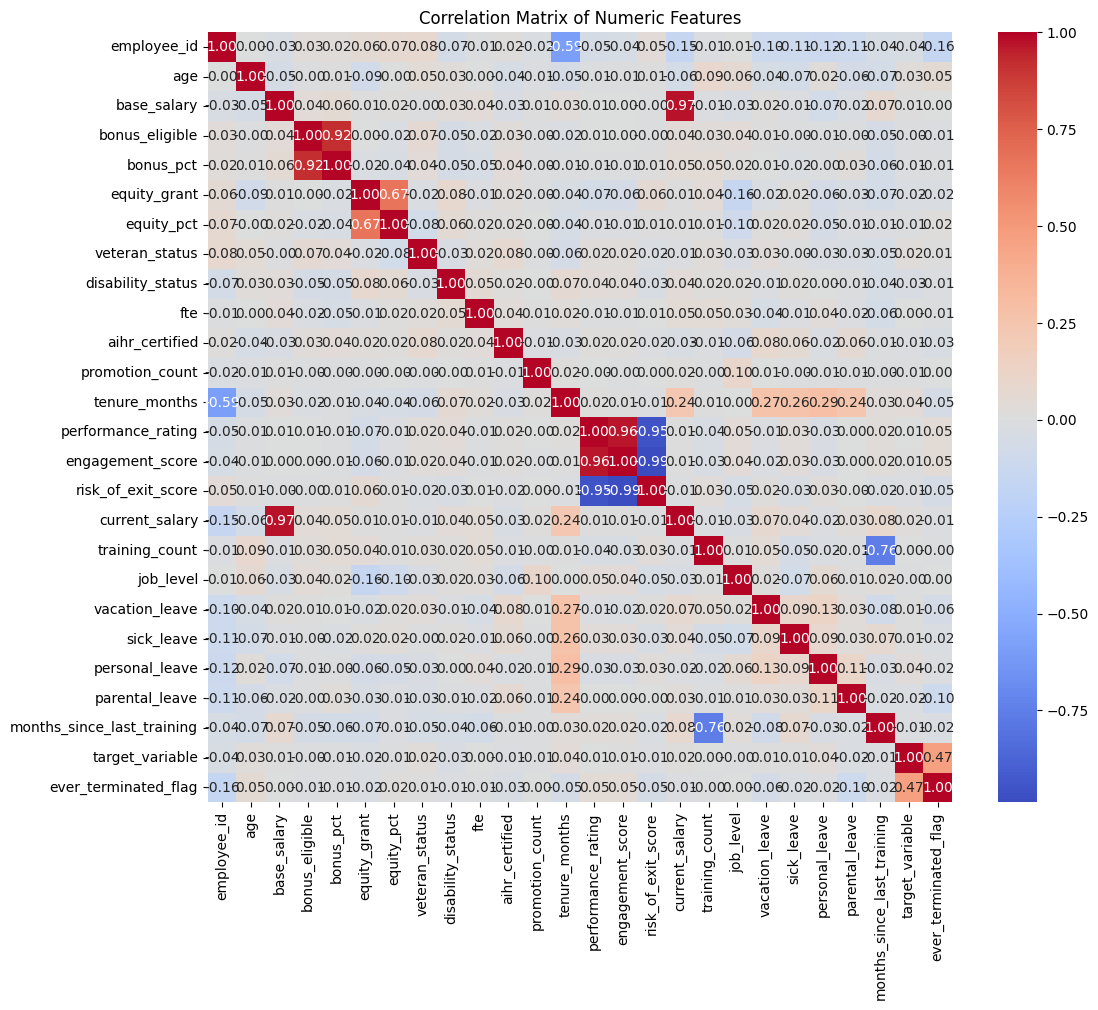

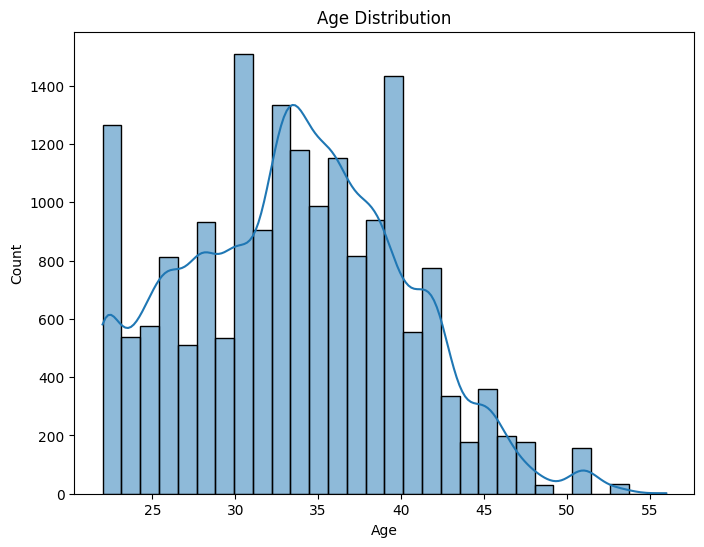

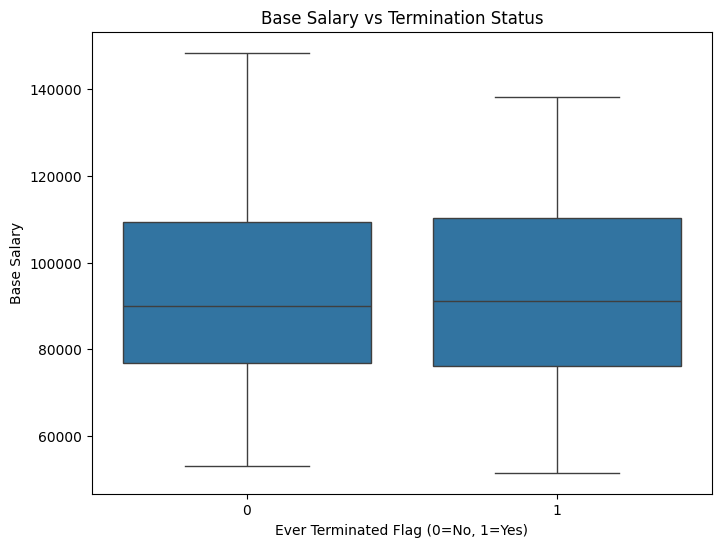

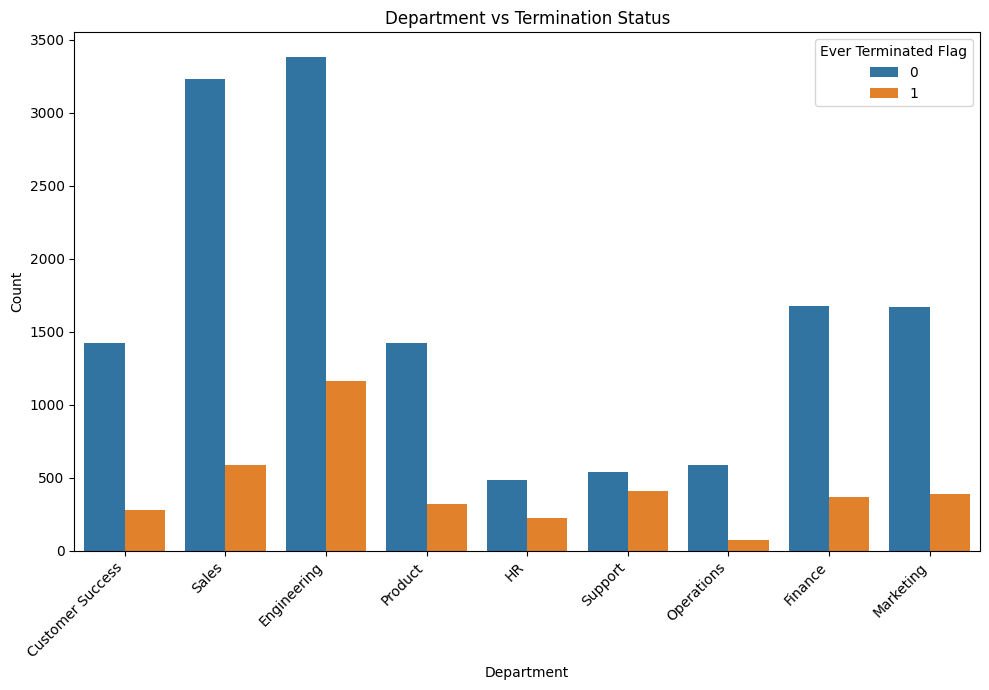

In [58]:
# EDA (from EDA.ipynb)

# Check target variable balance (original 'ever_terminated_flag' for initial understanding)
plt.figure(figsize=(6, 4))
sns.countplot(x='ever_terminated_flag', data=df)
plt.title('Original Target Variable Distribution (ever_terminated_flag)')
plt.show()

# Correlation matrix for numeric columns
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Boxplot of base salary by termination status
plt.figure(figsize=(8, 6))
sns.boxplot(x='ever_terminated_flag', y='base_salary', data=df)
plt.title('Base Salary vs Termination Status')
plt.xlabel('Ever Terminated Flag (0=No, 1=Yes)')
plt.ylabel('Base Salary')
plt.show()

# Countplot of department by termination status
plt.figure(figsize=(10, 7))
sns.countplot(x='department', hue='ever_terminated_flag', data=df)
plt.title('Department vs Termination Status')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Department')
plt.ylabel('Count')
plt.legend(title='Ever Terminated Flag')
plt.tight_layout()
plt.show()

# (Add any other relevant EDA plots or statistical summaries here)

## 4. Feature Engineering & Target Variable Creation
This crucial section defines and generates new features from existing data, and critically, constructs the precise target variable for the predictive model, specifically `ever_terminated_flag`.

In [59]:
# Feature Engineering & Target Variable Creation (from Preprocessing.ipynb)

# Convert dates to datetime objects
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['hire_date'] = pd.to_datetime(df['hire_date'])
df['termination_date'] = pd.to_datetime(df['termination_date'], errors='coerce') # Coerce errors for NaT

# Step 1: Sort data to correctly identify future events per employee
df = df.sort_values(by=['employee_id', 'snapshot_date']).reset_index(drop=True)

# Define the prediction horizon (e.g., 90 days for next quarter attrition)
PREDICTION_HORIZON_DAYS = 90

# Initialize the new target column for future attrition
df['target_variable'] = 0

# Loop through employees to determine if they terminated within the horizon
print(f"Calculating 'target_variable' with a {PREDICTION_HORIZON_DAYS}-day horizon...")
for employee_id in df['employee_id'].unique():
    employee_data = df[df['employee_id'] == employee_id].copy()
    
    # Get the actual termination date for this employee (earliest if multiple)
    actual_termination_date = employee_data['termination_date'].dropna().min()
    
    if pd.notna(actual_termination_date):
        # For each snapshot of this employee *before* their termination, check if they left within the horizon
        active_snapshots_before_term = employee_data[employee_data['snapshot_date'] < actual_termination_date].index
        
        for idx in active_snapshots_before_term:
            snapshot_date = df.loc[idx, 'snapshot_date']
            
            # If the actual termination date falls within the prediction horizon from this snapshot date
            if (actual_termination_date - snapshot_date).days <= PREDICTION_HORIZON_DAYS:
                df.loc[idx, 'target_variable'] = 1

print(f"Number of future terminations identified (1s): {df['target_variable'].sum()}")
print(f"Proportion of future terminations: {df['target_variable'].mean():.2%}")
print(f"Original 'ever_terminated_flag' (at snapshot) still present for comparison: {df['ever_terminated_flag'].sum()}")


# --- Additional Feature Engineering ---
df['months_since_hire'] = (df['snapshot_date'] - df['hire_date']).dt.days // 30
# Add more domain-specific features here if relevant (e.g., tenure at snapshot, recent performance changes)

Calculating 'target_variable' with a 90-day horizon...
Number of future terminations identified (1s): 396
Proportion of future terminations: 2.17%
Original 'ever_terminated_flag' (at snapshot) still present for comparison: 3811


## 5. Data Splitting & Preprocessing Pipeline
This section defines the features and target variable, splits the data into training and testing sets, and constructs the preprocessing pipelines for numerical and categorical features, including handling missing values and scaling/encoding.

In [60]:
# Data Splitting & Preprocessing Pipeline (from Preprocessing.ipynb)

# Define columns to exclude from the model's features (X)
model_features_to_exclude = ['employee_id', 'snapshot_date', 'hire_date', 'termination_date', 'ever_terminated_flag', 'risk_of_exit_score', 'target_variable']

# Define target (y) and features (X) for the model
X = df.drop(columns=['target_variable'] + model_features_to_exclude)
y = df['target_variable']

# Document features for audit and transparency
safe_features = X.columns.tolist() # Features going into the model
leakage_or_id_features = model_features_to_exclude # Columns excluded due to leakage or being identifiers

with open('safe_features.txt', 'w') as f:
    for feature in safe_features:
        f.write(f"{feature}\n")

with open('dropped_features.txt', 'w') as f:
    for feature in leakage_or_id_features:
        f.write(f"{feature}\n")

print("Safe features and dropped features documented in 'safe_features.txt' and 'dropped_features.txt'.")

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumeric Features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

# Split data into training and testing sets BEFORE preprocessing to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTrain set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")


# --- Preprocessing pipelines ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Handle missing numeric values
    ('scaler', StandardScaler()) # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # One-hot encode categorical features
])

# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

# Fit the preprocessor on the training data and transform both train/test sets
print("\nFitting preprocessor and transforming data...")
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print("Data transformation complete.")

# Get feature names after one-hot encoding for transformed dataframes
feature_names = preprocessor.get_feature_names_out()

Safe features and dropped features documented in 'safe_features.txt' and 'dropped_features.txt'.

Numeric Features (23): ['age', 'base_salary', 'bonus_eligible', 'bonus_pct', 'equity_grant', 'equity_pct', 'veteran_status', 'disability_status', 'fte', 'aihr_certified', 'promotion_count', 'tenure_months', 'performance_rating', 'engagement_score', 'current_salary', 'training_count', 'job_level', 'vacation_leave', 'sick_leave', 'personal_leave', 'parental_leave', 'months_since_last_training', 'months_since_hire']
Categorical Features (14): ['department', 'business_unit', 'job_title', 'location', 'employment_type', 'ethnicity', 'marital_status', 'education_level', 'pay_frequency', 'cost_center', 'exemption_status', 'high_potential_flag', 'succession_plan_status', 'last_training_date']

Train set shape: (14585, 37), Test set shape: (3647, 37)
Train target distribution:
target_variable
0    0.978265
1    0.021735
Name: proportion, dtype: float64
Test target distribution:
target_variable
0    

## 6. Handling Imbalance with SMOTE
This section specifically addresses class imbalance in the training data using the Synthetic Minority Over-sampling Technique (SMOTE) to ensure the model can learn effectively from the minority class.

In [61]:
# Handling Imbalance with SMOTE (from Preprocessing.ipynb)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE ONLY to the training data to prevent data leakage from the test set
print("\nApplying SMOTE to the training data...")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)
print("SMOTE resampling complete.")
print(f"Resampled training data shape: {X_train_resampled.shape}")
print(f"Resampled target distribution:\n{y_train_resampled.value_counts(normalize=True)}")


Applying SMOTE to the training data...
SMOTE resampling complete.
Resampled training data shape: (28536, 227)
Resampled target distribution:
target_variable
0    0.5
1    0.5
Name: proportion, dtype: float64


## 7. Model Training & Cross-Validation
This section focuses on training various machine learning models on the preprocessed and resampled training data and evaluating their performance using cross-validation.

In [62]:
# Model Training & Cross-Validation (from Modeling.ipynb)

print("\n--- Starting Model Training and Cross-Validation ---")

# ----- Random Forest Model -----
rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])
print("\nTraining Random Forest Classifier...")
rf_pipeline.fit(X_train_resampled, y_train_resampled)
rf_scores = cross_val_score(rf_pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Random Forest (5-fold CV) ROC AUC mean: {rf_scores.mean():.4f} (+/- {rf_scores.std() * 2:.4f})")


# ----- Logistic Regression Model -----
logreg_pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')) # 'liblinear' often good for small datasets
])
print("\nTraining Logistic Regression Classifier...")
logreg_pipeline.fit(X_train_resampled, y_train_resampled)
logreg_scores = cross_val_score(logreg_pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Logistic Regression (5-fold CV) ROC AUC mean: {logreg_scores.mean():.4f} (+/- {logreg_scores.std() * 2:.4f})")


# ----- XGBoost Model -----
xgb_pipeline = Pipeline(steps=[
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
print("\nTraining XGBoost Classifier...")
xgb_pipeline.fit(X_train_resampled, y_train_resampled)
xgb_scores = cross_val_score(xgb_pipeline, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"XGBoost (5-fold CV) ROC AUC mean: {xgb_scores.mean():.4f} (+/- {xgb_scores.std() * 2:.4f})")

print("\n--- Model Training and Cross-Validation Complete ---")


--- Starting Model Training and Cross-Validation ---

Training Random Forest Classifier...
Random Forest (5-fold CV) ROC AUC mean: 0.9997 (+/- 0.0013)

Training Logistic Regression Classifier...
Logistic Regression (5-fold CV) ROC AUC mean: 0.8742 (+/- 0.0074)

Training XGBoost Classifier...
XGBoost (5-fold CV) ROC AUC mean: 0.9990 (+/- 0.0036)

--- Model Training and Cross-Validation Complete ---


## 8. Model Evaluation on Test Set
This section evaluates the performance of the trained models on the unseen test set, providing comprehensive metrics and visualizations like classification reports, confusion matrices, and ROC curves.


--- Evaluating Models on Test Set ---

--- Classification Report - Random Forest ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3568
           1       0.58      0.23      0.33        79

    accuracy                           0.98      3647
   macro avg       0.78      0.61      0.66      3647
weighted avg       0.97      0.98      0.98      3647



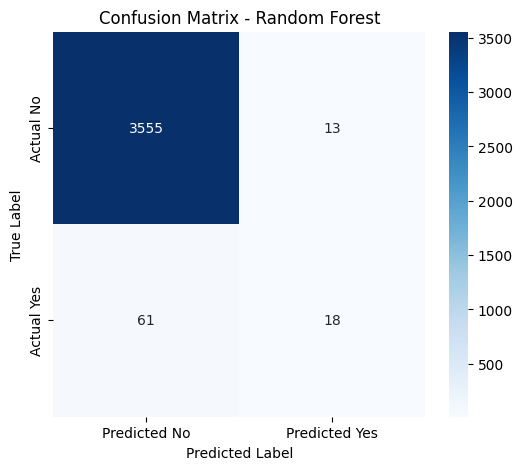

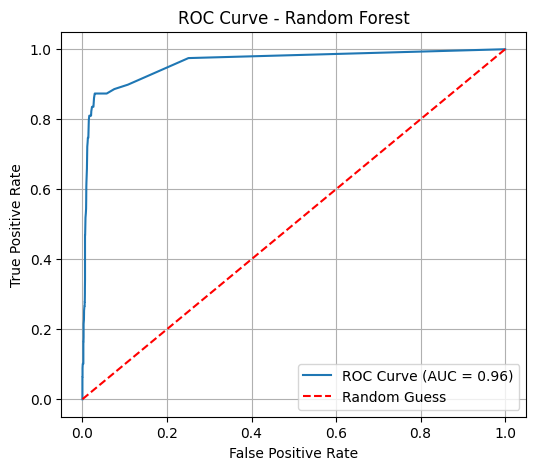


--- Classification Report - Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      3568
           1       0.05      0.58      0.09        79

    accuracy                           0.76      3647
   macro avg       0.52      0.67      0.48      3647
weighted avg       0.97      0.76      0.84      3647



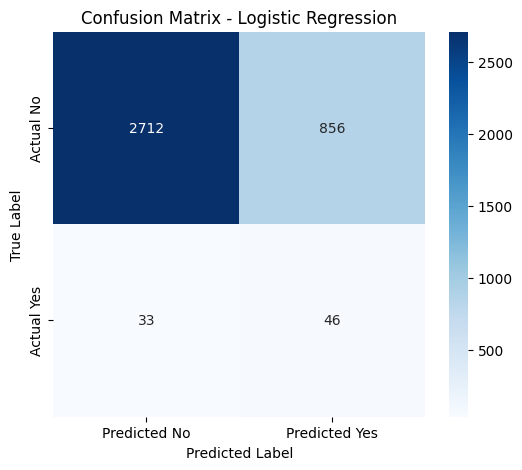

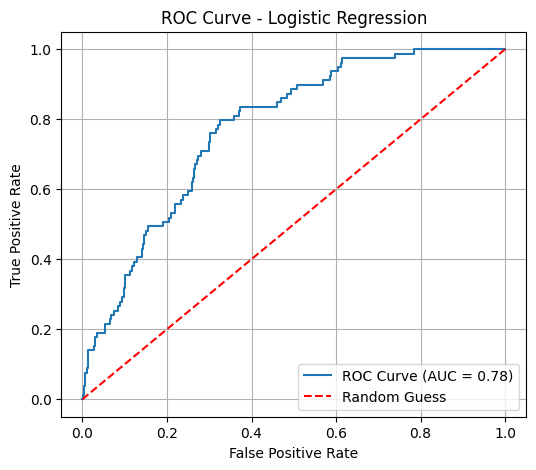


--- Classification Report - XGBoost ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3568
           1       0.33      0.16      0.22        79

    accuracy                           0.97      3647
   macro avg       0.66      0.58      0.60      3647
weighted avg       0.97      0.97      0.97      3647



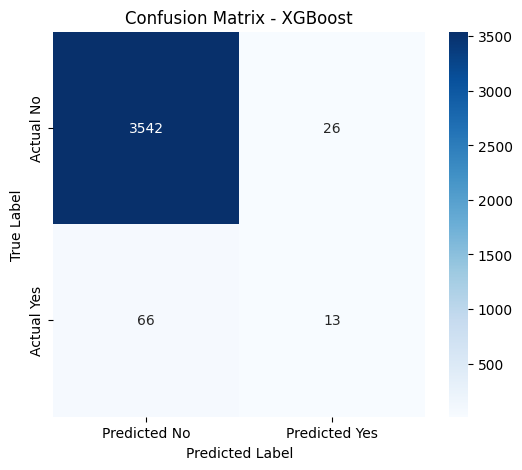

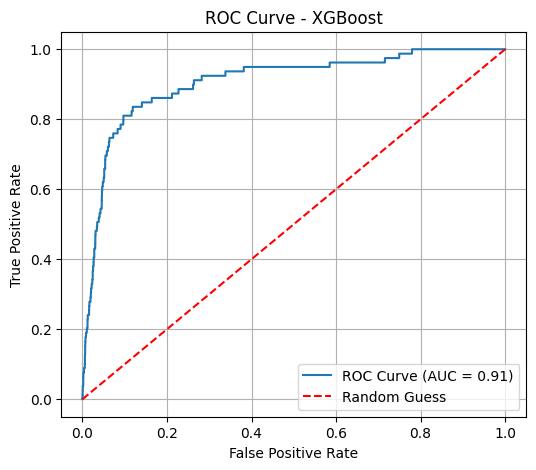


--- Test Set Evaluation Complete ---


In [63]:
# Model Evaluation on Test Set (from Modeling.ipynb)

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Evaluates a trained model on the test set and prints/plots relevant metrics.
    """
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"\n--- Classification Report - {model_name} ---")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return y_pred, y_proba

print("\n--- Evaluating Models on Test Set ---")
rf_pred, rf_proba = evaluate_model(rf_pipeline, X_test_transformed, y_test, 'Random Forest')
logreg_pred, logreg_proba = evaluate_model(logreg_pipeline, X_test_transformed, y_test, 'Logistic Regression')
xgb_pred, xgb_proba = evaluate_model(xgb_pipeline, X_test_transformed, y_test, 'XGBoost')
print("\n--- Test Set Evaluation Complete ---")

## 9. Model Interpretability (SHAP Values)
This section provides insights into how the models make predictions, specifically using SHAP (SHapley Additive exPlanations) values for the XGBoost model to understand feature contributions.


--- Generating SHAP Explanations for XGBoost Model ---


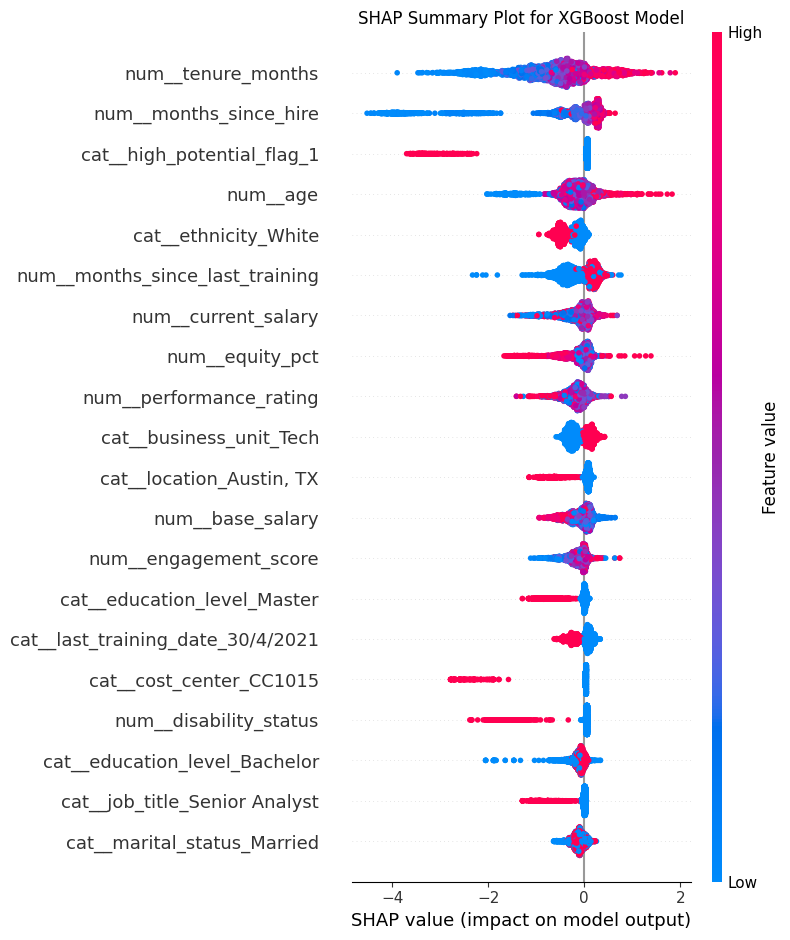


--- SHAP Explanations Complete ---


In [64]:
# Model Interpretability (SHAP Values) (from Modeling.ipynb)

print("\n--- Generating SHAP Explanations for XGBoost Model ---")

# SHAP explanations for XGBoost
xgb_model = xgb_pipeline.named_steps['classifier']
explainer_xgb = shap.TreeExplainer(xgb_model)

# The input X_test is already the transformed data the model expects
# Convert X_test_transformed to a DataFrame for better plotting labels in SHAP
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Calculate SHAP values
shap_values_xgb = explainer_xgb.shap_values(X_test_transformed_df)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_xgb, X_test_transformed_df, show=False)
plt.title('SHAP Summary Plot for XGBoost Model')
plt.tight_layout()
plt.show()

print("\n--- SHAP Explanations Complete ---")

## 10. Feature Importance & Model Coefficients
This section extracts and saves the feature importance scores or coefficients from the trained models, providing insights into which features were most influential in the predictions

In [65]:
# Feature Importance & Model Coefficients (from Modeling.ipynb)

print("\n--- Extracting and Saving Model Insights ---")

# Extract RF feature importances
rf_model = rf_pipeline.named_steps['classifier']
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
rf_feature_importance.to_csv('rf_feature_importance.csv', index=False)
print("Random Forest Feature Importance saved to 'rf_feature_importance.csv'")

# Extract Log Reg feature importances (coefficients)
logreg_model = logreg_pipeline.named_steps['classifier']
coefficients = logreg_model.coef_[0]
logreg_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False) # Sort by absolute value for impact
logreg_coef_df.to_csv('logreg_coefficients.csv', index=False)
print("Logistic Regression Coefficients saved to 'logreg_coefficients.csv'")

# Extract XGB feature importances
xgb_model = xgb_pipeline.named_steps['classifier']
xgb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)
xgb_feature_importance.to_csv('xgb_feature_importance.csv', index=False)
print("XGBoost Feature Importance saved to 'xgb_feature_importance.csv'")

print("\n--- Model Insights Extraction Complete ---")


--- Extracting and Saving Model Insights ---
Random Forest Feature Importance saved to 'rf_feature_importance.csv'
Logistic Regression Coefficients saved to 'logreg_coefficients.csv'
XGBoost Feature Importance saved to 'xgb_feature_importance.csv'

--- Model Insights Extraction Complete ---


## 11. Artifact Saving
This section is responsible for saving all necessary artifacts, including the trained preprocessor, resampled training data, transformed test data, and the full original test set with predictions, for future use or deployment.

In [66]:
# Artifact Saving (from Preprocessing.ipynb and Modeling.ipynb)

if overwrite_files:
    print("\n--- Saving Preprocessing and Modeling Artifacts ---")
    
    # Save preprocessor
    with open('preprocessor.pkl', 'wb') as f:
        pickle.dump(preprocessor, f)
    print("Preprocessor saved to 'preprocessor.pkl'")

    # Save the resampled training data
    pd.DataFrame(X_train_resampled, columns=feature_names).to_csv('X_train_resampled.csv', index=False)
    y_train_resampled.to_csv('y_train_resampled.csv', index=False)
    print("Resampled training data (X_train_resampled.csv, y_train_resampled.csv) saved.")

    # Save the transformed testing data
    pd.DataFrame(X_test_transformed, columns=feature_names).to_csv('X_test_transformed.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)
    print("Transformed testing data (X_test_transformed.csv, y_test.csv) saved.")

    # Save the FULL original test set data with new features and predictions
    # This 'df' still contains all original columns + new features like 'months_since_hire' and 'future_terminated_flag'.
    original_test_set_full_data = df.loc[X_test.index].copy() # Ensure we use the original indices from the split

    # Add model predictions and probabilities
    original_test_set_full_data['rf_prediction'] = rf_pred
    original_test_set_full_data['rf_probability'] = rf_proba
    original_test_set_full_data['logreg_prediction'] = logreg_pred
    original_test_set_full_data['logreg_probability'] = logreg_proba
    original_test_set_full_data['xgb_prediction'] = xgb_pred
    original_test_set_full_data['xgb_probability'] = xgb_proba

    # Rename future_terminated_flag to actual_terminated_flag for clarity in output
    original_test_set_full_data.rename(columns={'future_terminated_flag': 'actual_terminated_flag'}, inplace=True)

    # Save the final output file for business consumption (e.g., Tableau)
    original_test_set_full_data.to_csv('main_for_tableau.csv', index=False)
    print("Full original test set data with predictions saved to 'main_for_tableau.csv' for business intelligence.")
    print("Preprocessing and Modeling artifacts saved successfully.")
else:
    print("\noverwrite_files=False --> Skipping file save. Using existing processed CSV files and artifacts.")

print("\n--- Artifact Saving Complete ---")


--- Saving Preprocessing and Modeling Artifacts ---
Preprocessor saved to 'preprocessor.pkl'
Resampled training data (X_train_resampled.csv, y_train_resampled.csv) saved.
Transformed testing data (X_test_transformed.csv, y_test.csv) saved.
Full original test set data with predictions saved to 'main_for_tableau.csv' for business intelligence.
Preprocessing and Modeling artifacts saved successfully.

--- Artifact Saving Complete ---


## 12. Current Snapshot Generation for BI/Dashboarding
This section specifically prepares a 'current snapshot' dataset for business intelligence tools, containing only the latest, most relevant data for active employees, incorporating model predictions.

In [ ]:
# Current Snapshot Generation (from Current_Snapshot.ipynb)

print("\n--- Generating Current Snapshot for Active Employees ---")

# Ensure main_for_tableau.csv exists from previous steps
FULL_HISTORICAL_DATA_FILE = 'main_for_tableau.csv' 
try:
    full_data_with_predictions = pd.read_csv(FULL_HISTORICAL_DATA_FILE)
except FileNotFoundError:
    print(f"Error: '{FULL_HISTORICAL_DATA_FILE}' not found. Please ensure the previous steps ran successfully and saved this file.")
    exit() # Or handle more gracefully

# Ensure snapshot_date is in datetime format for proper sorting
full_data_with_predictions['snapshot_date'] = pd.to_datetime(full_data_with_predictions['snapshot_date'])
# Ensure employee_id is string if that's what Tableau expects, or consistent type.
full_data_with_predictions['employee_id'] = full_data_with_predictions['employee_id'].astype(str)

# --- Step 1: Get the latest snapshot for EACH unique employee ---
# Sort by employee_id first, then by snapshot_date in descending order to get the latest entry
full_data_sorted_by_latest = full_data_with_predictions.sort_values(by=['employee_id', 'snapshot_date'], ascending=[True, False])

# Drop duplicates on 'employee_id' while keeping the 'first' (which is the latest after sorting)
latest_per_employee_data_all = full_data_sorted_by_latest.drop_duplicates(subset=['employee_id'], keep='first').copy()

# --- Filter this comprehensive "latest snapshot" to include ONLY currently ACTIVE employees ---
# Define a recency threshold for "active" snapshots (e.g., snapshots from the current year or recent past)
# Adjust this threshold based on the data's recency and business needs.
# For example, if 'snapshot_date' can be old for still-active employees, you might need a different logic
# or rely solely on 'ever_terminated_flag'. Assuming a 'recent' snapshot implies active status.

recent_snapshot_threshold = pd.to_datetime('2025-01-01') # Example: only consider snapshots from 2024 onwards as 'recent'

current_snapshot = latest_per_employee_data_all[
    (latest_per_employee_data_all['ever_terminated_flag'] == 0) & # Employees not marked as terminated in the dataset
    (latest_per_employee_data_all['snapshot_date'] >= recent_snapshot_threshold) # And their latest snapshot is recent
].copy()

# Export this filtered data to a new CSV file
current_snapshot.to_csv('current_snapshot.csv', index=False)
print(f"Exported 'current_snapshot.csv' with the final snapshot for truly current, active employees.")
print(f"Number of employees in current_snapshot.csv after recency filter: {len(current_snapshot)}")

print("\n--- Current Snapshot Generation Complete ---")


--- Generating Current Snapshot for Active Employees ---
Exported 'current_snapshot.csv' with the final snapshot for truly current, active employees.
Number of employees in current_snapshot.csv after recency filter: 271

--- Current Snapshot Generation Complete ---
